In [1]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from matplotlib.ticker import FuncFormatter

## Merge and Clean Data

In [2]:
## clean esg data and fill in null values
price_df=pd.read_csv('614 price data.csv').set_index('Date')
price_df.index = pd.to_datetime(price_df.index, format='%Y/%m/%d')
esg_df=pd.read_csv('esg13-23.csv').set_index('Date')
esg_df.index = pd.to_datetime(esg_df.index, format='%Y/%m/%d')
esg_df.fillna(0, inplace=True)
esg_df.isnull()

,GM,ATI,LUV,DOW,SLM,CNP,COL,MS,DHR,AES,...,PARA,BALL,ELV,META,CEG,GEHC,RVTY,EG,KVUE,VLTO
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2013-01-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2013-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2013-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2013-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-24,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-03-25,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-03-26,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [3]:
# merge them to one dataframe
price_long = price_df.stack().reset_index()
price_long.columns = ['Date', 'Ticker', 'Price']
esg_long = esg_df.stack().reset_index()
esg_long.columns = ['Date', 'Ticker', 'ESG']
# 使用内部合并，确保只合并两个DataFrame都有的股票和日期
combined_df = pd.merge(price_long, esg_long, on=['Date', 'Ticker'], how='left')
# 输出查看结果
combined_df['Daily Return'] = combined_df.groupby('Ticker')['Price'].pct_change()

In [4]:
# filter Nan values to gurantee that the dataframe only contains stocks on each day

df=combined_df

filtered_df = pd.DataFrame()

# Iterate over each unique date
for date in df['Date'].unique():
    # Filter records where 'Daily Return' is not NaN for the current date
    daily_data = df[(df['Date'] == date) & (~df['Daily Return'].isnull())]
    
    # Select only the necessary columns
    daily_data = daily_data[['Date', 'Ticker', 'Daily Return','ESG']]
    
    # Before concatenation, ensure there are no entirely empty or NaN rows
    if not daily_data.empty:
        daily_data.dropna(how='all', inplace=True)
        filtered_df = pd.concat([filtered_df, daily_data], ignore_index=True)
filtered_df.set_index('Date', inplace=True)
price_long = price_df.stack().reset_index()
price_long.columns = ['Date', 'Ticker', 'Price']
esg_long = esg_df.stack().reset_index()
esg_long.columns = ['Date', 'Ticker', 'ESG']
combined_df = pd.merge(price_long, esg_long, on=['Date', 'Ticker'], how='left')
combined_df['Daily Return'] = combined_df.groupby('Ticker')['Price'].pct_change()

In [5]:
combined_df

,Date,Ticker,Price,ESG,Daily Return
0,2014-01-02,A,36.933754,7.0,NaN
1,2014-01-02,AAL,23.907925,0.0,NaN
2,2014-01-02,AAP,99.924667,2.0,NaN
3,2014-01-02,AAPL,17.296654,5.0,NaN
4,2014-01-02,ABBV,34.181690,3.0,NaN
...,...,...,...,...,...
1487436,2024-03-28,YUM,138.649994,4.0,0.009685
1487437,2024-03-28,ZBH,131.979996,6.0,-0.004751
1487438,2024-03-28,ZBRA,301.440002,5.0,0.007621
1487439,2024-03-28,ZION,43.400002,4.0,0.005794


In [6]:
# get mean vector, covariance matrix and esg vector in one table
# run time：2‘47’‘（around 3'）
def calculate_rolling_metrics(df, window_size, min_periods):
    rolling_results = []
    start_dates = pd.date_range(start=df.index.min(), 
                                end=df.index.max() - pd.Timedelta(days=window_size), 
                                freq='D')
    
    for start_date in start_dates:
        end_date = start_date + pd.Timedelta(days=window_size - 1)
        window_df = df.loc[start_date:end_date]

        # 对每只股票，找到窗口内最后一个非NaN的ESG值
        last_valid_esg = window_df.groupby('Ticker')['ESG'].apply(lambda x: x.last_valid_index() and x.loc[x.last_valid_index()])

        # 清理窗口数据，移除有NaN的行
        window_df = window_df.dropna(subset=['Daily Return'])

        # 确保每只股票在窗口期内的数据点至少达到最小数据点阈值
        valid_tickers = window_df.groupby('Ticker').filter(lambda x: len(x) >= min_periods)['Ticker'].unique()
        window_df = window_df[window_df['Ticker'].isin(valid_tickers)]

        # 计算平均日收益率
        expected_returns = window_df.groupby('Ticker')['Daily Return'].mean()

        # 计算协方差矩阵，使用成对完整观测值
        covariance_matrix = window_df.pivot(columns='Ticker', values='Daily Return').dropna(axis=0, how='any').cov()

        # 存储结果
        rolling_results.append({
            'Start_Date': start_date,
            'End_Date': end_date,
            'Expected_Returns': expected_returns,
            'Covariance_Matrix': covariance_matrix,
            'ESG_Scores': last_valid_esg
        })

    return pd.DataFrame(rolling_results)

# Set window size to 30 days and minimum periods for valid data points
WINDOW_SIZE = 30
MIN_PERIODS = 10

# Perform rolling window calculation
results_df = calculate_rolling_metrics(filtered_df, WINDOW_SIZE, MIN_PERIODS)

In [7]:
results_df

,Start_Date,End_Date,Expected_Returns,Covariance_Matrix,ESG_Scores
0,2014-01-03,2014-02-01,Ticker A 0.001798 AAL 0.014379 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 7.0 AAL 0.0 AAP 2.0 AAP...
1,2014-01-04,2014-02-02,Ticker A 0.001228 AAL 0.012687 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 7.0 AAL 0.0 AAP 2.0 AAP...
2,2014-01-05,2014-02-03,Ticker A -0.000553 AAL 0.012663 AAP ...,Ticker A AAL AAP ...,Ticker A 7.0 AAL 3.0 AAP 2.0 AAP...
3,2014-01-06,2014-02-04,Ticker A 0.000881 AAL 0.012187 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 7.0 AAL 3.0 AAP 2.0 AAP...
4,2014-01-07,2014-02-05,Ticker A 0.000802 AAL 0.010958 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 7.0 AAL 3.0 AAP 2.0 AAP...
...,...,...,...,...,...
3703,2024-02-23,2024-03-23,Ticker A 0.005355 AAL -0.001114 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 6.0 AAL 3.0 AAP 5.0 AAP...
3704,2024-02-24,2024-03-24,Ticker A 0.005618 AAL -0.000809 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 6.0 AAL 3.0 AAP 5.0 AAP...
3705,2024-02-25,2024-03-25,Ticker A 0.004741 AAL -0.000449 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 6.0 AAL 3.0 AAP 5.0 AAP...
3706,2024-02-26,2024-03-26,Ticker A 0.004166 AAL -0.000429 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 6.0 AAL 3.0 AAP 5.0 AAP...


In [7]:
# reset index of filtered_df
filtered_df.reset_index(inplace=True)
filtered_df.set_index(['Date','Ticker'], inplace=True)
filtered_df

Daily Return  ESG
Date       Ticker                   
2014-01-03 A           0.012631  7.0
           AAL         0.046530  0.0
           AAP         0.028613  2.0
           AAPL       -0.021966  5.0
           ABBV        0.006156  3.0
...                         ...  ...
2024-03-28 YUM         0.009685  4.0
           ZBH        -0.004751  6.0
           ZBRA        0.007621  5.0
           ZION        0.005794  4.0
           ZTS         0.004154  7.0

[1486827 rows x 2 columns]

## get monthly data for optimization

In [8]:
# a new DataFrame to store monthly data
monthly_results_df = results_df.iloc[::30, :].reset_index(drop=True)

# get ticker list for each row
monthly_results_df['Tickers'] = monthly_results_df['Expected_Returns'].apply(lambda x: list(x.keys()))

monthly_results_df

,Start_Date,End_Date,Expected_Returns,Covariance_Matrix,ESG_Scores,Tickers
0,2014-01-03,2014-02-01,Ticker A 0.001798 AAL 0.014379 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 7.0 AAL 0.0 AAP 2.0 AAP...,"[A, AAL, AAP, AAPL, ABBV, ABMD, ABT, ACGL, ACN..."
1,2014-02-02,2014-03-03,Ticker A -0.000975 AAL 0.003777 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 7.0 AAL 3.0 AAP 2.0 AAP...,"[A, AAL, AAP, AAPL, ABBV, ABMD, ABT, ACGL, ACN..."
2,2014-03-04,2014-04-02,Ticker A 0.000038 AAL 0.002226 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 7.0 AAL 3.0 AAP 2.0 AAP...,"[A, AAL, AAP, AAPL, ABBV, ABMD, ABT, ACGL, ACN..."
3,2014-04-03,2014-05-02,Ticker A -0.001617 AAL -0.001257 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 7.0 AAL 3.0 AAP 2.0 AAP...,"[A, AAL, AAP, AAPL, ABBV, ABMD, ABT, ACGL, ACN..."
4,2014-05-03,2014-06-01,Ticker A 0.002330 AAL 0.005120 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 7.0 AAL 3.0 AAP 2.0 AAP...,"[A, AAL, AAP, AAPL, ABBV, ABMD, ABT, ACGL, ACN..."
...,...,...,...,...,...,...
119,2023-10-13,2023-11-11,Ticker A -0.000023 AAL -0.000770 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 6.0 AAL 3.0 AAP 5.0 AAP...,"[A, AAL, AAP, AAPL, ABBV, ABNB, ABT, ACGL, ACN..."
120,2023-11-12,2023-12-11,Ticker A 0.008927 AAL 0.007744 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 6.0 AAL 3.0 AAP 5.0 AAP...,"[A, AAL, AAP, AAPL, ABBV, ABNB, ABT, ACGL, ACN..."
121,2023-12-12,2024-01-10,Ticker A 0.001075 AAL 0.002558 AAP ...,Ticker A AAL AAP ...,Ticker A 6.0 AAL 3.0 AAP 5.0 AAP...,"[A, AAL, AAP, AAPL, ABBV, ABNB, ABT, ACGL, ACN..."
122,2024-01-11,2024-02-09,Ticker A 0.000912 AAL 0.002438 AAP ...,Ticker A AAL AAP AAPL...,Ticker A 6.0 AAL 3.0 AAP 5.0 AAP...,"[A, AAL, AAP, AAPL, ABBV, ABNB, ABT, ACGL, ACN..."


## get daily return table that is used for prediction next month(already write into a csv file, don't need to run)

In [9]:
# upload next month return 
daily_return_cleaned = pd.read_csv('return_for_backtesting.csv')
# daily_return_cleaned['Date'] = pd.to_datetime(daily_return_cleaned['Date'])

In [31]:
# daily_return_cleaned=daily_return_cleaned.reset_index()
# daily_return_cleaned=daily_return_cleaned.set_index('Date')

In [10]:
daily_return_cleaned=daily_return_cleaned.set_index('Date')
daily_return_cleaned

,A,AAL,AAP,AAPL,ABBV,ABMD,ABT,ACGL,ACN,ADBE,...,CEG,DO,STI,GEHC,KVUE,EMC,FISV,VLTO,CA,YearMonth
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-03,-0.034394,0.012221,-0.039979,0.001858,-0.038189,-0.038559,-0.022095,-0.017469,-0.022408,-0.018584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02
2014-02-04,0.029564,0.002650,0.000272,0.014475,0.012672,-0.004162,0.011158,0.003215,-0.000128,0.028060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02
2014-02-05,-0.006574,-0.007342,0.004535,0.007469,-0.004588,-0.009119,0.002759,-0.003959,-0.006532,0.021433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02
2014-02-06,0.014975,0.025444,0.068121,0.005828,0.004190,0.016488,0.008253,-0.004732,0.012247,0.005574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02
2014-02-07,0.019386,0.029140,0.001121,0.013990,0.020030,0.021879,0.014461,0.003233,0.026235,0.025106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-04,0.027326,-0.054278,0.005775,-0.025381,-0.010396,NaN,0.011971,-0.000344,0.007139,-0.005237,...,0.035296,0.014346,0.120507,0.000108,0.007439,-0.005395,-0.002394,0.011296,-0.000198,2024-02
2024-03-05,0.010430,-0.009453,0.043066,-0.028441,0.011918,NaN,-0.012996,0.002869,-0.017800,-0.040673,...,0.004432,-0.022463,0.028302,-0.009921,0.002637,-0.008911,-0.000267,0.008662,0.000989,2024-02
2024-03-06,0.012955,0.014315,-0.010460,-0.005878,0.010605,NaN,0.007259,0.016363,0.010481,-0.003212,...,0.018159,0.003404,-0.007339,0.014051,0.029984,0.012901,0.004602,0.004181,0.000277,2024-02


## optimization with ESG constraints

In [64]:
def optimize_portfolio(expected_returns, ESG_scores, covariance_matrix, target_returns, min_esg_score, tickers):
    n = len(expected_returns)  # Number of assets
    m = Model("portfolio_optimization")

    # Add decision variables, one weight for each asset
    weights = m.addVars(n, lb=0, ub=1, name="weights")

    # Constraint: sum of weights equals 1
    m.addConstr(weights.sum() == 1, "sum_of_weights")

    # Initialize portfolio variance calculation
    portfolio_variance = quicksum(quicksum(weights[i] * covariance_matrix.iloc[i, j] * weights[j] 
                                           for j in range(n)) for i in range(n))

    optimized_results = []
    # Optimize for each target return
    for target_return in target_returns:
        # Adding constraints for return and ESG score
        return_constr = m.addConstr(quicksum(weights[i] * expected_returns[i] for i in range(n)) >= target_return, "return_target")
        esg_constr = m.addConstr(quicksum(weights[i] * ESG_scores[i] for i in range(n)) >= min_esg_score, "ESG_constraint")

        # Set objective: minimize portfolio variance
        m.setObjective(portfolio_variance, GRB.MINIMIZE)

        # Optimize the model
        m.optimize()

        # Collect results if the solution is optimal
        if m.status == GRB.OPTIMAL:
            optimized_results.append({
                'Risk': m.getObjective().getValue(),
                'Return': target_return,
                'Weights': [v.x for v in weights.values()],
                'Tickers': tickers
            })

        # Remove specific constraints for next optimization cycle
        m.remove(return_constr)
        m.remove(esg_constr)

    return optimized_results

In [65]:
def optimize_and_evaluate(row, esg_level, risk_level):
    expected_returns = np.array(row['Expected_Returns'])
    covariance_matrix = pd.DataFrame(row['Covariance_Matrix'])
    ESG_scores = np.array(row['ESG_Scores'])
    tickers = row['Tickers']  # Direct access to the list of tickers from the row
    target_returns = np.linspace(min(expected_returns), max(expected_returns), num=5)
    
    # Call the optimization function
    portfolio_results = optimize_portfolio(expected_returns, ESG_scores, covariance_matrix, target_returns, esg_level, tickers)

    # Convert the list of dictionaries to a DataFrame
    portfolio_df = pd.DataFrame(portfolio_results)
    if not portfolio_df.empty:
        # Find the portfolio closest to the desired risk level
        closest_portfolio = portfolio_df.iloc[(portfolio_df['Risk'] - risk_level).abs().argsort()[0]]
        weights_at_target_risk = closest_portfolio['Weights']

        # Map tickers to their respective weights
        ticker_weight_dict = dict(zip(tickers, weights_at_target_risk))
        return ticker_weight_dict
    return {ticker: None for ticker in tickers}  # Return a dictionary with None for each ticker if no valid portfolio is found

def backtester_parallel(esg_level, risk_level, monthly_results_df):
    # Run optimization in parallel
    results = Parallel(n_jobs=-1)(
        delayed(optimize_and_evaluate)(row, esg_level, risk_level) for index, row in monthly_results_df.iterrows())

    # Convert the list of dictionaries into a DataFrame
    results_df = pd.DataFrame(results, index=monthly_results_df.index)
    return results_df

In [101]:
optimized_result= backtester_parallel(3, 0.05, monthly_results_df)

Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Academic license - for non-commercial use only - expires 2024-09-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Academic license - for non-commercial use only - expires 2024-09-12
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Academic license - for non-commercial use only - expires 2024-09-12
Academic license - for non-commercial use only - expires 2024-09-12
Academic license - for non-commercial use only - expires 2024-09-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thr

In [102]:
# match weight with date
next_day = monthly_results_df['End_Date'] + pd.Timedelta(days=1)
optimized_result = optimized_result.set_index(next_day)
optimized_result.index = optimized_result.index.strftime('%Y-%m')

def multiply_values(row):
    # 获取该行的年月
    year_month = row['YearMonth']
    
    # 初始化组合价值为0，以防没有匹配的ticker或YearMonth
    row['portfolio value'] = 0
    
    # 对每个ticker列进行操作
    for ticker in optimized_result.columns:
        if ticker in row and not pd.isna(row[ticker]) and year_month in optimized_result.index:
            # 确保 optimized_result 在该 YearMonth 和 ticker 上有值
            if not pd.isna(optimized_result.at[year_month, ticker]):
                # 相乘并累加结果
                row['portfolio value'] += row[ticker] * optimized_result.at[year_month, ticker]
    
    return row

daily_return_backtesting = daily_return_cleaned.apply(multiply_values, axis=1)

In [104]:
daily_return_backtesting

,A,AAL,AAP,AAPL,ABBV,ABMD,ABT,ACGL,ACN,ADBE,...,DO,STI,GEHC,KVUE,EMC,FISV,VLTO,CA,YearMonth,portfolio value
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-03,-0.034394,0.012221,-0.039979,0.001858,-0.038189,-0.038559,-0.022095,-0.017469,-0.022408,-0.018584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-5.451951e-13
2014-02-04,0.029564,0.002650,0.000272,0.014475,0.012672,-0.004162,0.011158,0.003215,-0.000128,0.028060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,1.111111e-01
2014-02-05,-0.006574,-0.007342,0.004535,0.007469,-0.004588,-0.009119,0.002759,-0.003959,-0.006532,0.021433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-1.000000e-01
2014-02-06,0.014975,0.025444,0.068121,0.005828,0.004190,0.016488,0.008253,-0.004732,0.012247,0.005574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-1.111111e-01
2014-02-07,0.019386,0.029140,0.001121,0.013990,0.020030,0.021879,0.014461,0.003233,0.026235,0.025106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,3.769418e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-04,0.027326,-0.054278,0.005775,-0.025381,-0.010396,NaN,0.011971,-0.000344,0.007139,-0.005237,...,0.014346,0.120507,0.000108,0.007439,-0.005395,-0.002394,0.011296,-0.000198,2024-02,1.538462e-01
2024-03-05,0.010430,-0.009453,0.043066,-0.028441,0.011918,NaN,-0.012996,0.002869,-0.017800,-0.040673,...,-0.022463,0.028302,-0.009921,0.002637,-0.008911,-0.000267,0.008662,0.000989,2024-02,-2.222220e-02
2024-03-06,0.012955,0.014315,-0.010460,-0.005878,0.010605,NaN,0.007259,0.016363,0.010481,-0.003212,...,0.003404,-0.007339,0.014051,0.029984,0.012901,0.004602,0.004181,0.000277,2024-02,3.409094e-02


In [105]:
# # 去掉 3 sigma以外的 极值
# df['Date'] = pd.to_datetime(df['Date'])

# 定义处理极端值的函数
def replace_extreme_values(col):
    # 只处理数值类型的列
    if col.dtype == 'float64' or col.dtype == 'int64':
        mean = col.mean()
        std = col.std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        col = col.clip(lower=lower_bound, upper=upper_bound)
    return col

# 应用上述函数到除了日期列之外的所有列
daily_return_backtesting = daily_return_backtesting.apply(replace_extreme_values)

# 显示结果以验证
daily_return_backtesting

,A,AAL,AAP,AAPL,ABBV,ABMD,ABT,ACGL,ACN,ADBE,...,DO,STI,GEHC,KVUE,EMC,FISV,VLTO,CA,YearMonth,portfolio value
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-03,-0.034394,0.012221,-0.039979,0.001858,-0.038189,-0.038559,-0.022095,-0.017469,-0.022408,-0.018584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-5.451951e-13
2014-02-04,0.029564,0.002650,0.000272,0.014475,0.012672,-0.004162,0.011158,0.003215,-0.000128,0.028060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,1.111111e-01
2014-02-05,-0.006574,-0.007342,0.004535,0.007469,-0.004588,-0.009119,0.002759,-0.003959,-0.006532,0.021433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-1.000000e-01
2014-02-06,0.014975,0.025444,0.057337,0.005828,0.004190,0.016488,0.008253,-0.004732,0.012247,0.005574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-1.111111e-01
2014-02-07,0.019386,0.029140,0.001121,0.013990,0.020030,0.021879,0.014461,0.003233,0.026235,0.025106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,3.769418e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-04,0.027326,-0.054278,0.005775,-0.025381,-0.010396,NaN,0.011971,-0.000344,0.007139,-0.005237,...,0.014346,0.120507,0.000108,0.007439,-0.005395,-0.002394,0.011296,-0.000198,2024-02,1.462814e-01
2024-03-05,0.010430,-0.009453,0.043066,-0.028441,0.011918,NaN,-0.012996,0.002869,-0.017800,-0.040673,...,-0.022463,0.028302,-0.009921,0.002637,-0.008911,-0.000267,0.008662,0.000989,2024-02,-2.222220e-02
2024-03-06,0.012955,0.014315,-0.010460,-0.005878,0.010605,NaN,0.007259,0.016363,0.010481,-0.003212,...,0.003404,-0.007339,0.014051,0.029984,0.012901,0.004602,0.004181,0.000277,2024-02,3.409094e-02


## optimization without ESG constriants

In [106]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import pandas as pd

from gurobipy import Model, GRB, quicksum
import numpy as np
import pandas as pd

def optimize_portfolio_without_ESG(expected_returns, covariance_matrix, target_returns, tickers):
    n = len(expected_returns)  # Number of assets
    m = Model("portfolio_optimization")

    # Add decision variables, one weight for each asset
    weights = m.addVars(n, lb=0, ub=1, name="weights")

    # Constraint: sum of weights equals 1
    m.addConstr(weights.sum() == 1, "sum_of_weights")

    # Initialize portfolio variance calculation
    portfolio_variance = quicksum(quicksum(weights[i] * covariance_matrix.iloc[i, j] * weights[j] 
                                           for j in range(n)) for i in range(n))

    optimized_results = []
    # Optimize for each target return
    for target_return in target_returns:
        # Adding constraint for return
        return_constr = m.addConstr(quicksum(weights[i] * expected_returns[i] for i in range(n)) >= target_return, "return_target")

        # Set objective: minimize portfolio variance
        m.setObjective(portfolio_variance, GRB.MINIMIZE)

        # Optimize the model
        m.optimize()

        # Collect results if the solution is optimal
        if m.status == GRB.OPTIMAL:
            optimized_results.append({
                'Risk': m.getObjective().getValue(),
                'Return': target_return,
                'Weights': [v.x for v in weights.values()],
                'Tickers': tickers
            })

        # Remove specific constraints for next optimization cycle
        m.remove(return_constr)

    return optimized_results

In [108]:
def optimize_and_evaluate_without_ESG(row, risk_level):
    expected_returns = np.array(row['Expected_Returns'])
    covariance_matrix = pd.DataFrame(row['Covariance_Matrix'])
    tickers = row['Tickers']  # Direct access to the list of tickers from the row
    target_returns = np.linspace(min(expected_returns), max(expected_returns), num=5)
    
    # Call the optimization function
    portfolio_results = optimize_portfolio_without_ESG(expected_returns, covariance_matrix, target_returns, tickers)

    # Convert the list of dictionaries to a DataFrame
    portfolio_df = pd.DataFrame(portfolio_results)
    if not portfolio_df.empty:
        # Find the portfolio closest to the desired risk level
        closest_portfolio = portfolio_df.iloc[(portfolio_df['Risk'] - risk_level).abs().argsort()[0]]
        weights_at_target_risk = closest_portfolio['Weights']

        # Map tickers to their respective weights
        ticker_weight_dict = dict(zip(tickers, weights_at_target_risk))
        return ticker_weight_dict
    return {ticker: None for ticker in tickers}  # Return a dictionary with None for each ticker if no valid portfolio is found

from joblib import Parallel, delayed

def backtester_parallel_without_ESG(risk_level, monthly_results_df):
    # Run optimization in parallel
    results = Parallel(n_jobs=-1)(
        delayed(optimize_and_evaluate_without_ESG)(row, risk_level) for index, row in monthly_results_df.iterrows())

    # Convert the list of dictionaries into a DataFrame
    results_df = pd.DataFrame(results, index=monthly_results_df.index)
    return results_df

In [109]:
optimized_result= backtester_parallel_without_ESG(0.05, monthly_results_df)

Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Academic license - for non-commercial use only - expires 2024-09-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Academic license - for non-commercial use only - expires 2024-09-12
Academic license - for non-commercial use only - expires 2024-09-12
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12
Academic license - for non-commercial use only - expires 2024-09-12
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thr

In [110]:
# match weight with date
next_day = monthly_results_df['End_Date'] + pd.Timedelta(days=1)
optimized_result = optimized_result.set_index(next_day)
optimized_result.index = optimized_result.index.strftime('%Y-%m')

def multiply_values(row):
    # 获取该行的年月
    year_month = row['YearMonth']
    
    # 初始化组合价值为0，以防没有匹配的ticker或YearMonth
    row['portfolio value'] = 0
    
    # 对每个ticker列进行操作
    for ticker in optimized_result.columns:
        if ticker in row and not pd.isna(row[ticker]) and year_month in optimized_result.index:
            # 确保 optimized_result 在该 YearMonth 和 ticker 上有值
            if not pd.isna(optimized_result.at[year_month, ticker]):
                # 相乘并累加结果
                row['portfolio value'] += row[ticker] * optimized_result.at[year_month, ticker]
    
    return row

daily_return_backtesting_without_ESG = daily_return_cleaned.apply(multiply_values, axis=1)

In [111]:
daily_return_backtesting_without_ESG

,A,AAL,AAP,AAPL,ABBV,ABMD,ABT,ACGL,ACN,ADBE,...,DO,STI,GEHC,KVUE,EMC,FISV,VLTO,CA,YearMonth,portfolio value
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-03,-0.034394,0.012221,-0.039979,0.001858,-0.038189,-0.038559,-0.022095,-0.017469,-0.022408,-0.018584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-8.078120e-13
2014-02-04,0.029564,0.002650,0.000272,0.014475,0.012672,-0.004162,0.011158,0.003215,-0.000128,0.028060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,1.111111e-01
2014-02-05,-0.006574,-0.007342,0.004535,0.007469,-0.004588,-0.009119,0.002759,-0.003959,-0.006532,0.021433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-1.000000e-01
2014-02-06,0.014975,0.025444,0.068121,0.005828,0.004190,0.016488,0.008253,-0.004732,0.012247,0.005574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-1.111111e-01
2014-02-07,0.019386,0.029140,0.001121,0.013990,0.020030,0.021879,0.014461,0.003233,0.026235,0.025106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,5.348223e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-04,0.027326,-0.054278,0.005775,-0.025381,-0.010396,NaN,0.011971,-0.000344,0.007139,-0.005237,...,0.014346,0.120507,0.000108,0.007439,-0.005395,-0.002394,0.011296,-0.000198,2024-02,1.538462e-01
2024-03-05,0.010430,-0.009453,0.043066,-0.028441,0.011918,NaN,-0.012996,0.002869,-0.017800,-0.040673,...,-0.022463,0.028302,-0.009921,0.002637,-0.008911,-0.000267,0.008662,0.000989,2024-02,-2.222220e-02
2024-03-06,0.012955,0.014315,-0.010460,-0.005878,0.010605,NaN,0.007259,0.016363,0.010481,-0.003212,...,0.003404,-0.007339,0.014051,0.029984,0.012901,0.004602,0.004181,0.000277,2024-02,3.409094e-02


In [112]:
# 定义处理极端值的函数
def replace_extreme_values(col):
    # 只处理数值类型的列
    if col.dtype == 'float64' or col.dtype == 'int64':
        mean = col.mean()
        std = col.std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        col = col.clip(lower=lower_bound, upper=upper_bound)
    return col

# 应用上述函数到除了日期列之外的所有列
daily_return_backtesting_without_ESG = daily_return_backtesting_without_ESG.apply(replace_extreme_values)

# 显示结果以验证
daily_return_backtesting_without_ESG

,A,AAL,AAP,AAPL,ABBV,ABMD,ABT,ACGL,ACN,ADBE,...,DO,STI,GEHC,KVUE,EMC,FISV,VLTO,CA,YearMonth,portfolio value
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-03,-0.034394,0.012221,-0.039979,0.001858,-0.038189,-0.038559,-0.022095,-0.017469,-0.022408,-0.018584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-8.078120e-13
2014-02-04,0.029564,0.002650,0.000272,0.014475,0.012672,-0.004162,0.011158,0.003215,-0.000128,0.028060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,1.111111e-01
2014-02-05,-0.006574,-0.007342,0.004535,0.007469,-0.004588,-0.009119,0.002759,-0.003959,-0.006532,0.021433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-1.000000e-01
2014-02-06,0.014975,0.025444,0.057337,0.005828,0.004190,0.016488,0.008253,-0.004732,0.012247,0.005574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,-1.111111e-01
2014-02-07,0.019386,0.029140,0.001121,0.013990,0.020030,0.021879,0.014461,0.003233,0.026235,0.025106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02,5.348223e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-04,0.027326,-0.054278,0.005775,-0.025381,-0.010396,NaN,0.011971,-0.000344,0.007139,-0.005237,...,0.014346,0.120507,0.000108,0.007439,-0.005395,-0.002394,0.011296,-0.000198,2024-02,1.538462e-01
2024-03-05,0.010430,-0.009453,0.043066,-0.028441,0.011918,NaN,-0.012996,0.002869,-0.017800,-0.040673,...,-0.022463,0.028302,-0.009921,0.002637,-0.008911,-0.000267,0.008662,0.000989,2024-02,-2.222220e-02
2024-03-06,0.012955,0.014315,-0.010460,-0.005878,0.010605,NaN,0.007259,0.016363,0.010481,-0.003212,...,0.003404,-0.007339,0.014051,0.029984,0.012901,0.004602,0.004181,0.000277,2024-02,3.409094e-02


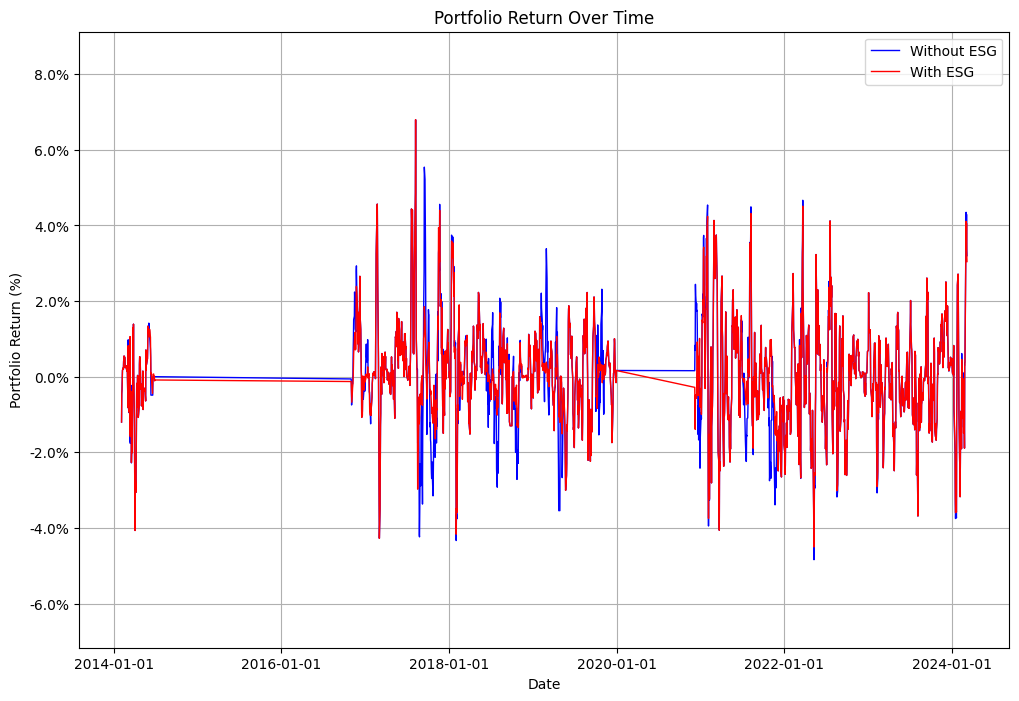

In [116]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Calculate the expanded y-axis range
range_min = min(rolling_mean_without_ESG.min(), rolling_mean_with_ESG.min())
range_max = max(rolling_mean_without_ESG.max(), rolling_mean_with_ESG.max())
expanded_range_min = range_min - (range_max - range_min) * 0.2  # Expand 20% below minimum
expanded_range_max = range_max + (range_max - range_min) * 0.2  # Expand 20% above maximum

# Setup plot
plt.figure(figsize=(12, 8))

# Plot both rolling means
plt.plot(daily_return_backtesting_without_ESG.index, rolling_mean_without_ESG, linestyle='-', color='blue', alpha=1, linewidth=1, label='Without ESG')
plt.plot(daily_return_backtesting.index, rolling_mean_with_ESG, linestyle='-', color='red', alpha=1, linewidth=1, label='With ESG')

# Formatting and labels
plt.title('Portfolio Return Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Return (%)')
plt.grid(True)
plt.legend()

# Function to format y-axis as percentage
def to_percent(y, position):
    s = f"{y:.1f}"
    return f"{s}%"

# Apply percentage formatting to y-axis
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
# Date formatting on the x-axis
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))  # Adjust date format as needed

# Set y-axis limits with expanded range
plt.ylim([expanded_range_min, expanded_range_max])

# Show the plot
plt.show()

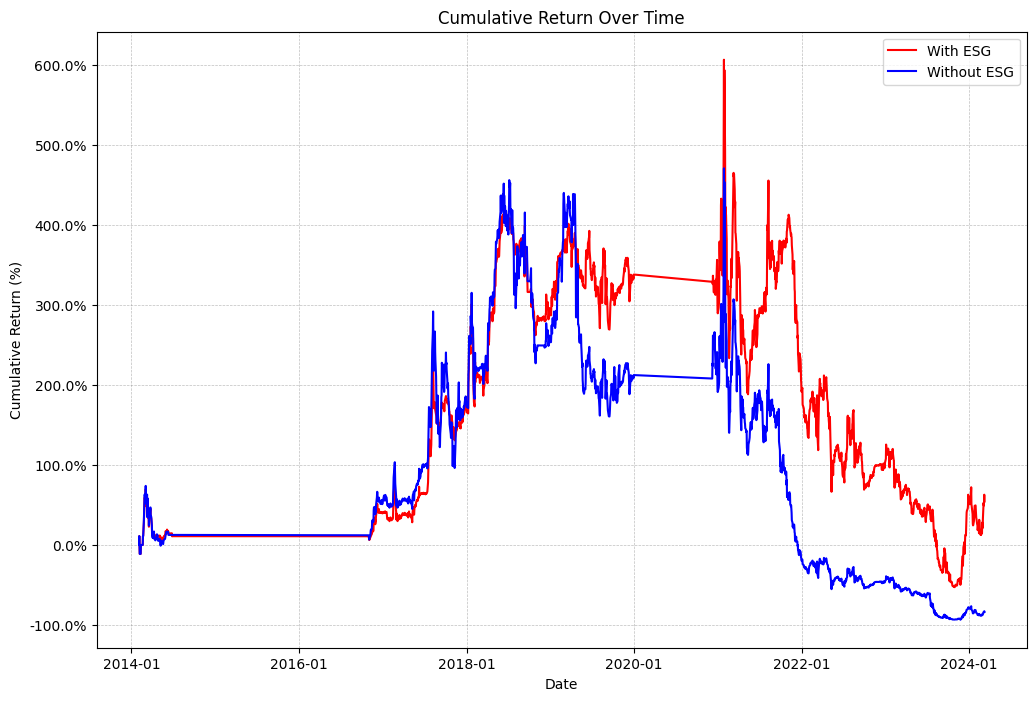

In [117]:
# Convert indices to datetime if they aren't already
daily_return_backtesting.index = pd.to_datetime(daily_return_backtesting.index)
daily_return_backtesting_without_ESG.index = pd.to_datetime(daily_return_backtesting_without_ESG.index)

# Calculate cumulative returns for each DataFrame
cumulative_return_with_ESG = (1 + daily_return_backtesting['portfolio value']).cumprod() - 1
cumulative_return_without_ESG = (1 + daily_return_backtesting_without_ESG['portfolio value']).cumprod() - 1

# Convert to percentage
cumulative_return_with_ESG *= 100
cumulative_return_without_ESG *= 100

# Setup plot
plt.figure(figsize=(12, 8))

# Plot cumulative returns
plt.plot(daily_return_backtesting.index, cumulative_return_with_ESG, linestyle='-', color='red', label='With ESG')
plt.plot(daily_return_backtesting_without_ESG.index, cumulative_return_without_ESG, linestyle='-', color='blue', label='Without ESG')

# Formatting and labels
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()

# Date formatting on the x-axis
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Adjust according to your data range

# Function to format y-axis as percentage
def to_percent(y, position):
    """Format number as percentage for matplotlib."""
    s = f"{y:.1f}"
    return f"{s}%"

formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

# Show the plot
plt.show()